# import

try tf.data to decrease the I/O time

In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.4.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [3]:
# impirt the lib
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import scipy.io
import os
from os import walk
from os.path import join

import sys
import random
from sklearn.model_selection import train_test_split

from scipy.io import loadmat
from os import listdir
from PIL import Image
import collections
from math import pi, sqrt, exp

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, Flatten, ActivityRegularization, BatchNormalization,GaussianNoise
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [4]:
def gauss(n=6,sigma=1):
    r = range(-int(n/2),int(n/2)+1)
    return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]

gaussfilter = gauss()

In [5]:
def ShowChaLoc(arraysize,channelID=[],xpos=[],ypos=[],show=True):
	if (channelID==[])& ((xpos==[]) or (ypos==[])):
		sys.exit('input channelID, or, xpos and ypos')
	if channelID != []:
		inlen = list(range(arraysize[0]*arraysize[1]))
		allindex = np.array(inlen)[channelID]
		xpos = np.int_(allindex / arraysize[0])
		ypos = np.int_(allindex % arraysize[1])
	if xpos.shape != ypos.shape:
		sys.exit('xpos and ypos have to be the same shape')
	if (max(xpos) > arraysize[0]) or (max(ypos) > arraysize[1]):
		sys.exit('xpos and ypos bigger than arraysize ???')
	imgbk=np.zeros(arraysize)
	for x,y in zip(xpos,ypos):
		imgbk[x,y]+=1
	if show == True:
		plt.imshow(imgbk)
		plt.show()
	else:
		return imgbk

In [6]:
def Tina_CNN(n_out,inshape = (49,49,40)):
    inputs = Input(shape=inshape )
    x = Conv2D(8, (15,15), kernel_regularizer=l2(0.01))(inputs) # (height, width)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.05)(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (11,11), kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.05)(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dense(n_out, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.05)(x)
    outputs = Activation('softplus')(x)
    return Model(inputs, outputs, name='Tina_CNN')

In [7]:
def PlotTotalfiring(targetrate,CNNrate, init=30000,n_data = 1000):
	final = init+n_data
	fig, ax1 = plt.subplots()
	ax1.plot(np.sum(targetrate,axis=0)[init:final],'b',lw=2.5)
	ax1.set_xlabel('time (datapoint/10ms)', fontsize='16')
	ax1.set_ylabel('target', color='b', fontsize='16')
	ax1.tick_params('y',colors='b')
	ax2 = ax1.twinx()
	ax2.plot((np.sum(CNNrate,axis=0)[init:final]-min(np.sum(CNNrate,axis=0)[init:final])),'r')
	ax2.set_ylabel('CNN', color='r', fontsize='16')
	ax2.tick_params('y',colors='r')
	plt.show()

# laod data

## Select channels: useful channel decided by the number of spikes

In [8]:
spkfolder = '/dockerCNN/RetinaCNN/20200729Leo/'
spkfile = 'merge_20200219saccade.mat'

file = spkfolder+spkfile
mat = scipy.io.loadmat(file)

In [9]:
print(file)
for fori in mat:
    print(fori)

/dockerCNN/RetinaCNN/20200729Leo/merge_20200219saccade.mat
__header__
__version__
__globals__
Video
TimeStamps
BinningInterval
diode_BT
bin_pos
reconstruct_spikes


In [10]:
TimeStamps = mat.get('TimeStamps')[0]
# spikes=mat.get('sorted_spikes')
spikes=mat.get('reconstruct_spikes')
BinningInterval = mat.get('BinningInterval')
bin_pos = mat.get('bin_pos')[0]
binningrate=[]
imgidx = []
bins = np.linspace(0, TimeStamps[1]-TimeStamps[0], num=bin_pos.shape[0]+1)
for i in range(60):
    out = np.histogram(spikes[0][i], bins=bins)
    dump = np.convolve(out[0],gaussfilter,mode='same')
    binningrate.append(dump[39:-1])
# imgidx.append(bin_pos[0])
    
print(len(bin_pos))
print(np.array(binningrate).shape)

ChTotalFiring = sum(np.array(binningrate).T).astype('int')
for loopcount,fori in enumerate(ChTotalFiring):
    print(loopcount+1,fori)

180057
(60, 180017)
1 303
2 688
3 1014
4 13020
5 8387
6 483
7 743
8 209
9 715
10 838
11 10759
12 11869
13 191
14 152
15 561
16 453
17 232
18 1190
19 882
20 95
21 18063
22 10178
23 705
24 453
25 2039
26 1285
27 181
28 3593
29 8236
30 2082
31 26164
32 798
33 8426
34 3583
35 2607
36 1971
37 10183
38 7928
39 5884
40 684
41 3824
42 2530
43 1337
44 6734
45 13694
46 6724
47 500
48 1234
49 858
50 1764
51 1833
52 4672
53 6667
54 277
55 466
56 994
57 4090
58 1467
59 6532
60 822


In [11]:
channelID = np.where((sum(np.array(binningrate).T)>1500)&(sum(np.array(binningrate).T)<30000))
print(channelID[0]+1)
print('# channel=',len(channelID[0]))
channelIDLoc = channelID[0].copy()
idx1 = [channelID[0]<6]
idx2 = [(6<=channelID[0])&(channelID[0]<54)]
idx3 = [54<=channelID[0]]
channelIDLoc[idx1]+=1
channelIDLoc[idx2]+=2
channelIDLoc[idx3]+=3

ShowChaLoc([8,8],channelID=channelIDLoc)

[ 4  5 11 12 21 22 25 28 29 30 31 33 34 35 36 37 38 39 41 42 44 45 46 50
 51 52 53 57 59]
# channel= 29


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result e

## load data

In [12]:
allspikes=np.array(binningrate)[channelID].T
print(allspikes.shape)


(180017, 29)


In [17]:
imgfilestemp[-10:]

['stimulus.179951.npy',
 'stimulus.179952.npy',
 'stimulus.179953.npy',
 'stimulus.179954.npy',
 'stimulus.179955.npy',
 'stimulus.179956.npy',
 'stimulus.179957.npy',
 'stimulus.179958.npy',
 'stimulus.179959.npy',
 'stimulus.179960.npy']

In [15]:
imgfilder = '/TinaData/CNNImage/20200223imagestack/'
imgfilestemp = os.listdir(imgfilder)
imgfilestemp.sort()
imgfiles = []
for fori in bin_pos:
    imgfiles.append(imgfilder+imgfilestemp[fori-1])
print(len(imgfiles))

IndexError: list index out of range

In [14]:
imgfiles[:10]

['/TinaData/CNNImage/20200223image/stimulus.000001.jpeg',
 '/TinaData/CNNImage/20200223image/stimulus.000002.jpeg',
 '/TinaData/CNNImage/20200223image/stimulus.000003.jpeg',
 '/TinaData/CNNImage/20200223image/stimulus.000004.jpeg',
 '/TinaData/CNNImage/20200223image/stimulus.000005.jpeg',
 '/TinaData/CNNImage/20200223image/stimulus.000006.jpeg',
 '/TinaData/CNNImage/20200223image/stimulus.000007.jpeg',
 '/TinaData/CNNImage/20200223image/stimulus.000008.jpeg',
 '/TinaData/CNNImage/20200223image/stimulus.000009.jpeg',
 '/TinaData/CNNImage/20200223image/stimulus.000010.jpeg']

In [ ]:
tf.data.TextLineDataset(filenames)

In [13]:
if len(imgfiles)-40 != len(allspikes):
    import warnings
    warnings.warn('data size does not match', UserWarning)

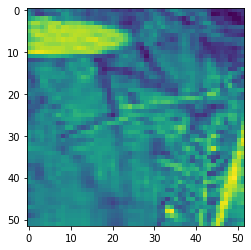

In [14]:
aimg = mpimg.imread(imgfiles[0])
CNNW = aimg.shape[0]
CNNH = aimg.shape[1]

plt.imshow(aimg)
plt.show()

In [15]:
allimages = np.zeros((len(imgfiles),CNNW,CNNH))

In [16]:
for count,i in enumerate(imgfiles):
    allimages[count] = mpimg.imread(i)/255.0

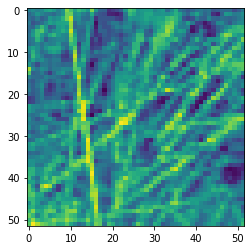

In [18]:
plt.imshow(allimages[0])
plt.show()
plt.imshow(allimages[1000])
plt.show()

# training a CNN

In [ ]:
# %%script false 

# from package_Tina.PlotResult import PlotTotalfiring

# import importlib
# importlib.reload(PlotResult)

## define batch reader

In [30]:
def generate_inputs(trainspk,trainimg, batchsize):
    while 1 : 
        loadcount = 0
        for dump in range(batchsize):
            # keep looping until we reach our batch size
            tempimgstack = trainimg[loadcount:loadcount+batchsize+40]
            imgstack = np.transpose([tempimgstack[j:-(40-j)] for j in range(40)],axes=[1,2,3,0])
            targetspikes = trainspk[loadcount:loadcount+batchsize]
            loadcount += batchsize
            yield (imgstack, targetspikes)

In [48]:
testinput1 = generate_inputs(trainspk,trainimg, batchsize)

In [58]:
testimg,testspk = testinput1.__next__()

print(testspk.shape)

print(testimg.shape)

(1024, 29)
(1024, 52, 52, 40)


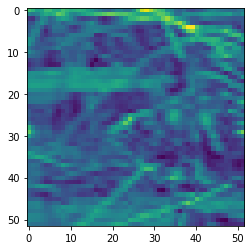

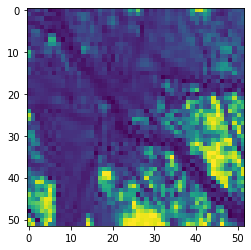

In [59]:
plt.imshow(testimg[0,:,:,0])
plt.show()
plt.imshow(testimg[1000,:,:,0])
plt.show()
plt.imshow(testimg[1000,:,:,-1])
plt.show()

## set parameters

In [20]:
splitratio = 0.8
N_epochs = 100
batchsize=1024

In [21]:
trainlen = int((len(allspikes)*splitratio//batchsize)*batchsize)
testlen =int(((len(allspikes)-trainlen)//batchsize)*batchsize)
print('trainlen=',trainlen,' testlen=',testlen)

trainlen= 143360  testlen= 35840


In [22]:
trainspk = allspikes[:trainlen]
trainimg = allimages[:trainlen+40]
testspk = allspikes[trainlen:]
testimg = allimages[trainlen:]
print('trainspk=',len(trainspk),'trainimg=',len(trainimg),'testspk=',len(testspk),'testimg=',len(testimg))

trainspk= 143360 trainimg= 143400 testspk= 36657 testimg= 36697


In [28]:
steps_per_epoch = len(trainspk)//batchsize # num_samples // batch_size
Ntrain = batchsize*steps_per_epoch
print('batchsize=',batchsize, ', steps_per_epoch=',steps_per_epoch)

batchsize= 1024 , steps_per_epoch= 140


## training

In [23]:
tf.executing_eagerly()

True

In [24]:
### disable eager mode to speed up training

tf.executing_eagerly()

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

tf.executing_eagerly()

False

In [60]:
n_out = len(channelID[0])
model = Tina_CNN(n_out,inshape = (CNNW,CNNH,40))
model.summary()

Model: "Tina_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 52, 52, 40)]      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 8)         72008     
_________________________________________________________________
batch_normalization_3 (Batch (None, 38, 38, 8)         32        
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, 38, 38, 8)         0         
_________________________________________________________________
activation_3 (Activation)    (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 8)         7752      
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 8)         32 

In [61]:
# mcpvalloss_save = ModelCheckpoint("20191208serialbestval.h5", save_best_only=True, monitor='val_loss', mode='min')

adam_tune=keras.optimizers.Adam(lr=0.001)
model.compile(loss='poisson', optimizer=adam_tune)
model.fit(generate_inputs(trainspk,trainimg, batchsize),
          steps_per_epoch=steps_per_epoch, epochs=N_epochs*2,
          shuffle=False)

Epoch 1/200
140/140 [==============================] - 119s 842ms/step - batch: 69.5000 - size: 1024.0000 - loss: 0.7795
Epoch 2/200
140/140 [==============================] - 1s 9ms/step - batch: 69.5000 - size: 0.0000e+00 - loss: 0.0040
Epoch 3/200
 19/140 [===>..........................] - ETA: 1s - batch: 9.0000 - size: 0.0000e+00 - loss: 3.6107e-04

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/callbacks.py:918: RuntimeWarning: invalid value encountered in double_scalars
  logs[k] = self.totals[k] / self.seen


140/140 [==============================] - 1s 9ms/step - batch: 69.5000 - size: 0.0000e+00 - loss: 1.5020e-04
Epoch 4/200
140/140 [==============================] - 1s 9ms/step - batch: 69.5000 - size: 0.0000e+00 - loss: 1.0106e-05
Epoch 5/200
140/140 [==============================] - 1s 10ms/step - batch: 69.5000 - size: 0.0000e+00 - loss: 4.6778e-07
Epoch 6/200
140/140 [==============================] - 1s 10ms/step - batch: 69.5000 - size: 0.0000e+00 - loss: 1.2981e-08
Epoch 7/200
140/140 [==============================] - 1s 9ms/step - batch: 69.5000 - size: 0.0000e+00 - loss: 2.0863e-10
Epoch 8/200
140/140 [==============================] - 81s 584ms/step - batch: 69.5000 - size: 702.1714 - loss: nan
Epoch 9/200
 15/140 [==>...........................] - ETA: 1:44 - batch: 7.0000 - size: 1024.0000 - loss: nan

KeyboardInterrupt: 

## save the trained model

In [ ]:
# %%script false 
model.save('David20200418_CNN20200223_a1.h5')

## train more ...

In [ ]:
adam_tune=keras.optimizers.Adam(lr=0.0005)
model.compile(loss='poisson', optimizer=adam_tune)
model.fit_generator(generate_arrays_from_file(trainspk,trainimg, batchsize, steps_per_epoch),steps_per_epoch=steps_per_epoch, epochs=N_epochs*2)

In [ ]:
model.save('David20200418_CNN20200223_a2.h5')

In [ ]:
adam_tune=keras.optimizers.Adam(lr=0.0001)
model.compile(loss='poisson', optimizer=adam_tune)
model.fit_generator(generate_arrays_from_file(trainspk,trainimg, batchsize, steps_per_epoch),steps_per_epoch=steps_per_epoch, epochs=N_epochs*2)

In [ ]:
model.save('David20200418_CNN20200223_a3.h5')

# study the CNN

## load a trained model

In [ ]:
n_out = allspikes.shape[1]
aimg = mpimg.imread(imgfiles[0])
CNNW = aimg.shape[0]
CNNH = aimg.shape[1]
def Tina_CNN(n_out):
    inputs = Input(shape=(CNNW,CNNH,40))
    x = Conv2D(8, (15,15), kernel_regularizer=l2(0.01))(inputs) # (height, width)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.05)(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (11,11), kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.05)(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dense(n_out, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.05)(x)
    outputs = Activation('softplus')(x)
    return Model(inputs, outputs, name='Tina_CNN')

model = Tina_CNN(n_out)
model.load_weights('/home/tina/disk/TensorflowCodeTina/CoremTest/David20200418_CNN20200223_a3.h5')

In [ ]:
def generate_ImgSpkData(spkfile,trainimage):
    tempimgstack = [mpimg.imread(i)/255.0 for i in trainimage]
    imgstack = np.transpose([tempimgstack[j:-(40-j)] for j in range(40)],axes=[1,2,3,0])
    targetspikes = spkfile
    return imgstack, targetspikes



In [ ]:
print(allspikes.shape,len(imgfiles))

In [ ]:
startidx = 3000
usedlen = 30000
spkused = allspikes[startidx:startidx+usedlen]
imgused = imgfiles[startidx:startidx+usedlen+40]
imgstack, targetspikes = generate_ImgSpkData(spkused,imgused)


In [ ]:
# %%script false 
pred = model.predict(imgstack, verbose=1)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(sum(targetspikes.T))
plt.plot(sum(pred.T))
plt.xlim([0,1000])
plt.show()

In [ ]:
sig = sum(targetspikes.T)
from scipy import signal
corr = signal.correlate(sig, sig, mode='same')
plt.plot(corr)
plt.xlim([1000,1200])
plt.show()

## kernals of the CNN

In [ ]:
def get_layer_output(model, model_inputs, outputlayer=3, training_flag=False, plot_flag=False, batchnum=0, kernelnum=0):
    from keras import backend as K
    get_output = K.function([model.layers[0].input, K.learning_phase()],[model.layers[outputlayer].output])
    layer_output = get_output([model_inputs, training_flag])[0]
    if plot_flag:
        plt.imshow(outs[batchnum,:,:,kernelnum])
        plt.show()
    return layer_output
# outputs = [layer.output for layer in model.layers]          # all layer outputs
# functors = [K.function([inp]+ [K.learning_phase()], [out]) for out in outputs] # evaluation functions

def get_kernel(model, layerID=0, channelID=0, kernelID=0):
    modelconfig=model.get_config()
    modelweight=model.get_weights()
    tempkernel = np.squeeze(modelweight[layerID][:,:,channelID,kernelID])
    return tempkernel

In [ ]:
# %%script false 

layerID = 0
Nchannel = model.get_weights()[layerID].shape[2]
Nkernel = model.get_weights()[layerID].shape[3]
for j in range(Nkernel):
    for i in range(Nchannel):
        print("NKernel", j)
        print("Nchannel", i)
        plt.imshow(get_kernel(model, layerID=layerID, channelID=i, kernelID=j))
        plt.colorbar()
        plt.show()

## receptive field (RF) of the COREM and CNN

In [ ]:
def ReceptiveField3D(FiringRate, npfolderpath=None, imgstack=None):
	RFallimage = np.zeros((FiringRate.shape[0],40,CNNW,CNNH))
	channelID = 0
	if (imgstack is None) and (npfolderpath is None):
		print("input npfolderpath or imgstack")
		npfolderpath=input("npfolderpath=")
	if npfolderpath is not None:
		print("npfolderpath")
		files = listdir(npfolderpath)
		files.sort()
		for j in FiringRate:
			spikeind = np.nonzero((j>np.std(j))*1)[0]+39
			for i in spikeind:
				for k in range(40):
					RFallimage[channelID,39-k,:,:] += np.load(npfolderpath+files[i-k])
			RFallimage[channelID,:,:,:] = RFallimage[channelID,:,:,:]/len(spikeind)
			channelID += 1   
	else:
		print("imgstack")
		imgstack = np.transpose(imgstack,axes=[0,3,1,2])
		for j in FiringRate:
			spikeind = np.nonzero((j>np.std(j))*1)[0]
			for i in spikeind:
				RFallimage[channelID,:,:,:] += imgstack[i]
			RFallimage[channelID,:,:,:] = RFallimage[channelID,:,:,:]/len(spikeind)
			channelID += 1
	return RFallimage

In [ ]:
imgstack.shape
targetspikes.shape

In [ ]:
RFCOREM3D = ReceptiveField3D(targetspikes.T,imgstack=imgstack)
RFCNN3D = ReceptiveField3D(pred.T,imgstack=imgstack)
for i,j,k in zip(RFCOREM3D,RFCNN3D,channelIDLoc):
    plt.subplot(1, 3, 1)
    plt.imshow(i[-1,:,:])
    plt.subplot(1, 3, 2)
    plt.imshow(j[-1,:,:])
    plt.subplot(1, 3, 3)
    plt.imshow(ShowChaLoc([8,8],channelID=[k],show=False))
    plt.show()

# apply the stimuli

## on off stimulus

In [ ]:
def onoffsti(data,savepng = False, outputpath='/home/hydrolab/Desktop/COREM-Tina/COREM/input_sequences'):
    if savepng == False:        
        imgback = np.zeros((len(data),CNNW,CNNH))
        for i in range(len(data)) :
            idex = [data[i]]*CNNW*CNNH
            checker = np.reshape(idex,(CNNW,CNNH))
            imgback[i,:,:]= checker
        return imgback
    if savepng == True:
        os.chdir(outputpath)
        expday = datetime.datetime.now().strftime("%Y_%m_%d")
        if not os.path.exists(expday+'_onoffimg'):
            os.makedirs(expday+'_onoffimg')
        outimgpath = os.getcwd()+'/'+expday+'_onoffimg'
        for count in range(len(data)) :
            idex = [data[count]*255]*2401
            checker = np.reshape(idex,(CNNW,CNNH)).astype('uint8')
            imgname = outimgpath+'/stimulus_'+'%05d' % count+'.png'
            im = Image.fromarray(checker)
            im.save(imgname)
        print('finish save onoff sti', imgname)

In [ ]:
onoffbase = ([[1]*50+[0]*50]*10)
onoffdata = [item for sublist in onoffbase for item in sublist]
onoffimg = onoffsti(onoffdata)
onoffimgstack = np.transpose([onoffimg[i:-(40-i)] for i in range(40)],axes=[1,2,3,0])

In [ ]:
onoffpred = model.predict(onoffimgstack)
onofftotalint = np.sum((np.sum(onoffimg,axis=1)),axis=1)[39:-1]

In [ ]:
from package_Tina.PlotResult import plotyy_Tina

In [ ]:
plotyy_Tina(onofftotalint,sum(onoffpred.T),xrange=[0,1000],label=['sti','CNN'])

In [ ]:
for i in onoffpred.T:
    plotyy_Tina(onofftotalint,i,xrange=[200,400],label=['sti','CNN'])

## bar stimulus

In [ ]:
def reversedbar(x=[],savepng=False, outputpath='/home/hydrolab/Desktop/COREM-Tina/COREM/input_sequences'):
	if x ==[]:
		x = (list(range(CNNW))+list(range(CNNH))[::-1])*60
	if savepng==False:
		imgback = np.zeros((len(x),CNNW,CNNH))
		for i,pos in enumerate(x) :
			imgback[i,pos,:]=1
		return x, imgback
	if savepng==True:
		os.chdir(outputpath)
		expday = datetime.datetime.now().strftime("%Y_%m_%d")
		if not os.path.exists(expday+'_barimg'):
		    os.makedirs(expday+'_barimg')
		outimgpath = os.getcwd()+'/'+expday+'_barimg'
		for count, pos in enumerate(x) :
			imgback = np.zeros((CNNW,CNNH))
			imgback[pos,:]=255
			checker = imgback.astype('uint8')
			imgname = outimgpath+'/stimulus_'+'%05d' % count+'.png'
			im = Image.fromarray(checker)
			im.save(imgname)
		print('finish save checker', imgname)

In [ ]:
x, barimg = reversedbar()

In [ ]:
barimgstack = np.transpose([np.array(barimg)[i:-(40-i)] for i in range(40)],axes=[1,2,3,0])

In [ ]:
barpred = model.predict(barimgstack)
bartotalint = np.sum((np.sum(barimg,axis=1)),axis=1)[39:-1]

In [ ]:
plotyy_Tina(np.array(x[39:-1]),sum(barpred.T),xrange=[0,500],label=['sti','CNN'])

In [ ]:
for count,i in enumerate(barpred.T):
    plt.imshow(ShowChaLoc([8,8],channelID=[channelIDLoc[count]],show=False))
    plt.show()
    plotyy_Tina(np.array(x[39:-1]),i,xrange=[0,1000],label=['sti','CNN'])

## HMM whole field

In [ ]:
from random import gauss

def HMM(Delta = 0.1, Gamma = 0.2, sDD = 0.01,dt=0.01):
    # Generate HMM time series
    omega2 = (Gamma/(2*1.06))**2
    xs = []
    vs = []
    x = 0
    v = 0
    tt = [] # time index
    for i in range(20000):
        tt.append(i)
        tp = x
        x = x+v*dt
        v = (1-Gamma*dt)*v-omega2*tp*dt+gauss(0,sDD)*(Delta*dt)**0.5
        xs.append(x)
        vs.append(v)
    return xs,vs

def OU(Delta = 0.1,Gamma = 5.0,sDD = 0.1,dt=0.01):
    xs = []
    x = 0 
    for i in range(10000):
        tp = x
        x = (1-dt*Gamma/(2.12)**2)*x+gauss(0,sDD)*(Delta*dt)**0.5
        xs.append(x)
    return xs

In [ ]:
HMMxs,_ = HMM()
plt.plot(xs)
plt.show()

In [ ]:
HMMonoffimg = onoffsti(HMMxs)
HMMonoffimgstack = np.transpose([HMMonoffimg[i:-(40-i)] for i in range(40)],axes=[1,2,3,0])
HMMonoffpred = model.predict(HMMonoffimgstack)
HMMonofftotalint = np.sum((np.sum(HMMonoffimg,axis=1)),axis=1)[39:-1]
plotyy_Tina(HMMonofftotalint,sum(HMMonoffpred.T),xrange=[0,1000],label=['sti','CNN'])